<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250219%5D%20Implement%20hybrid%20model%20with%20FGSM%26PGD%20adversarial%20on%20NF-ToN-IoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hybrid model With PGD adversarial training**

In [ ]:
!pip uninstall -y foolbox
!pip uninstall -y foolbox-native

In [ ]:
!pip install foolbox==3.3.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.1 MB/s eta 0:00:00


**🔹 Step 1: Data Preprocessing (Save to File)**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
#import foolbox as fb  # For CW and PGD attacks

In [ ]:
# --- Load and preprocess dataset ---
dataset = pd.read_csv("Dataset_NF-ToN-IoT.csv").dropna()
for column in dataset.columns:
    if dataset[column].dtype == 'object':
        dataset[column] = LabelEncoder().fit_transform(dataset[column])
X = dataset.drop(['Class'], axis=1)
y = dataset['Class']

In [ ]:
print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [ 70436   3828  53825   1727 442801   1174 121617     22   9790  99913]


In [ ]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Apply SMOTE for class balance
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)
# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [442801 442801 442801 442801 442801 442801 442801 442801 442801 442801]


In [ ]:
import pickle

# ✅ Save preprocessed data
with open("preprocessed_data.pkl", "wb") as f:
    pickle.dump((X, y), f)

print("✅ Preprocessed data saved!")

✅ Preprocessed data saved!


In [ ]:
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# ✅ Load preprocessed data
with open("preprocessed_data.pkl", "rb") as f:
    X, y = pickle.load(f)

# ✅ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Train Logistic Regression for Feature Extraction
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42)
lr_model.fit(X_train, y_train)

# ✅ Extract probabilities for BiLSTM
train_lr_features = lr_model.predict_proba(X_train)
test_lr_features = lr_model.predict_proba(X_test)
train_lr_features = np.expand_dims(train_lr_features, axis=1)
test_lr_features = np.expand_dims(test_lr_features, axis=1)

# ✅ One-hot encode labels
num_classes = len(np.unique(y))
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# ✅ Save features
with open("lr_features.pkl", "wb") as f:
    pickle.dump((train_lr_features, test_lr_features, y_train_encoded, y_test_encoded), f)

print("✅ Logistic Regression features saved!")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Logistic Regression features saved!


**🔹 Step 3: Hybrid LR-BiLSTM Training**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.regularizers import l2
import pickle

# ✅ Load Logistic Regression features
with open("lr_features.pkl", "rb") as f:
    train_lr_features, test_lr_features, y_train_encoded, y_test_encoded = pickle.load(f)

# ✅ Define BiLSTM Model
bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0001)), input_shape=(1, train_lr_features.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(32, kernel_regularizer=l2(0.0001))),
    Dropout(0.2),
    Dense(y_train_encoded.shape[1], activation="softmax")
])
bilstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# ✅ Train model
history = bilstm_model.fit(train_lr_features, y_train_encoded, validation_split=0.2, epochs=50, batch_size=64, verbose=1)

# ✅ Save trained model
bilstm_model.save("bilstm_model.h5")
print("✅ BiLSTM Model saved!")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
44281/44281 ━━━━━━━━━━━━━━━━━━━━ 208s 5ms/step - accuracy: 0.9981 - loss: 0.0518 - val_accuracy: 0.9999 - val_loss: 0.0018
Epoch 2/50
44281/44281 ━━━━━━━━━━━━━━━━━━━━ 196s 4ms/step - accuracy: 0.9999 - loss: 0.0020 - val_accuracy: 0.9999 - val_loss: 0.0017
Epoch 3/50
44281/44281 ━━━━━━━━━━━━━━━━━━━━ 198s 4ms/step - accuracy: 0.9999 - loss: 0.0018 - val_accuracy: 0.9999 - val_loss: 0.0015
Epoch 4/50
44281/44281 ━━━━━━━━━━━━━━━━━━━━ 196s 4ms/step - accuracy: 0.9999 - loss: 0.0018 - val_accuracy: 0.9999 - val_loss: 0.0015
Epoch 5/50
44281/44281 ━━━━━━━━━━━━━━━━━━━━ 199s 4ms/step - accuracy: 0.9999 - loss: 0.0019 - val_accuracy: 0.9999 - val_loss: 0.0015
Epoch 6/50
44281/44281 ━━━━━━━━━━━━━━━━━━━━ 202s 5ms/step - accuracy: 0.9999 - loss: 0.0018 - val_accuracy: 0.9999 - val_loss: 0.0017
Epoch 7/50
44281/44281 ━━━━━━━━━━━━━━━━━━━━ 199s 4ms/step - accuracy: 0.9999 - loss: 0.0019 - val_accuracy: 0.9999 - val_loss: 0.0014
Epoch 8/50
44281/44281 ━━━━━━━━━━━━━━━━━━━━ 205s 5ms/step - ac

✅ BiLSTM Model saved!


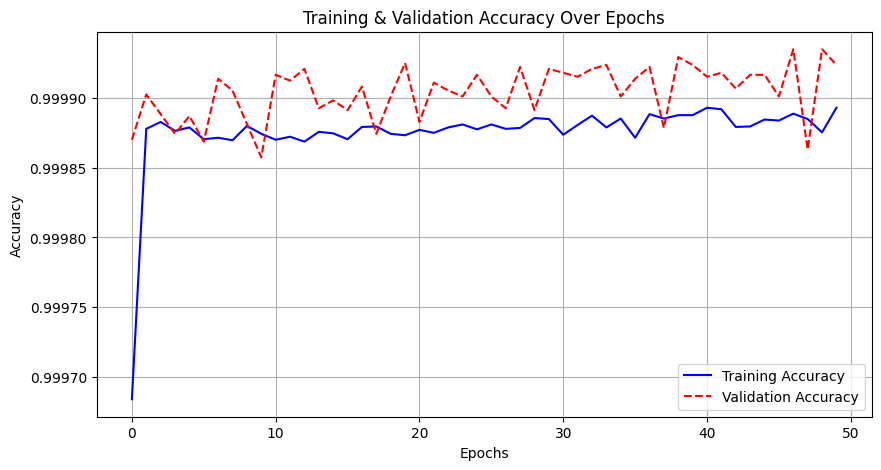

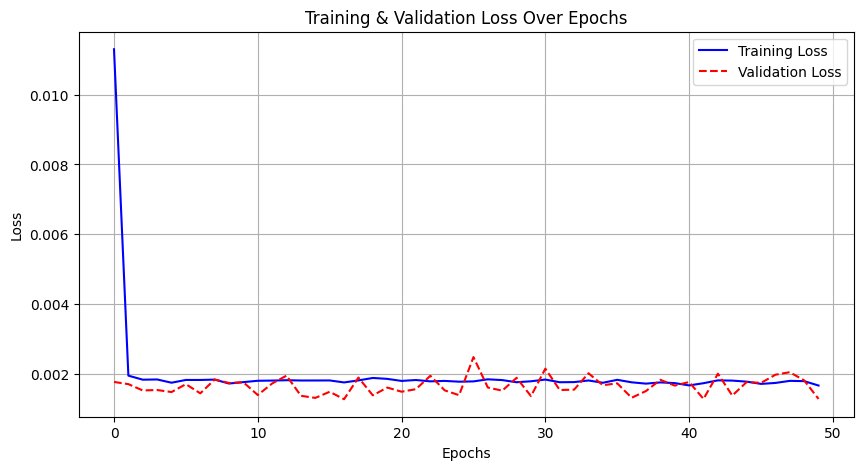

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is obtained from model training
#history = bilstm_model.fit(
    #train_lr_features, y_train_encoded,
    #validation_split=0.2,
    #epochs=50,
    #batch_size=64,
    #verbose=1
#)

# Plot Training & Validation Accuracy Trends
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label="Training Accuracy", color="blue")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy", color="red", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training & Validation Loss Trends
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label="Training Loss", color="blue")
plt.plot(history.history['val_loss'], label="Validation Loss", color="red", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

27676/27676 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step


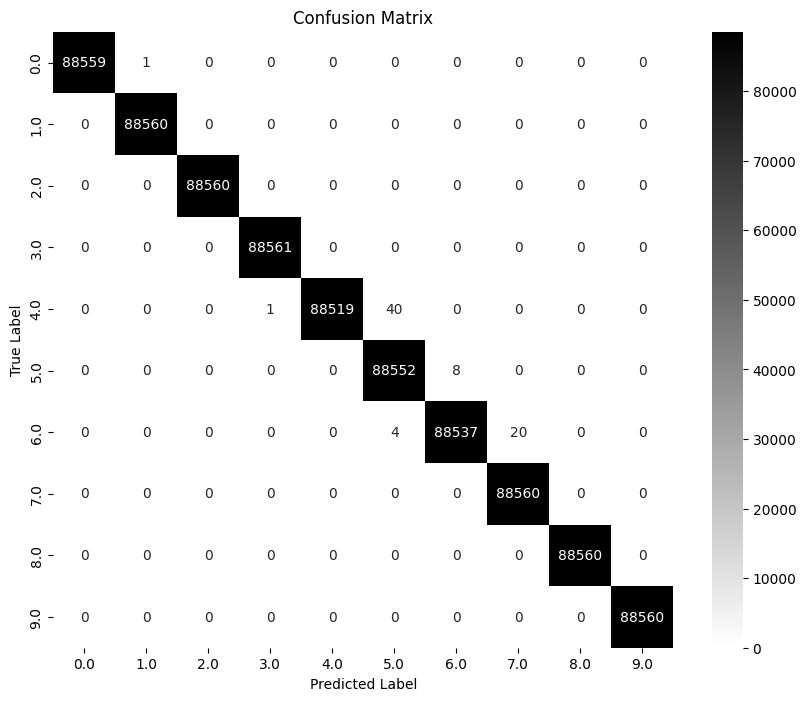

In [ ]:
# prompt: Please display Confusion Matrix in Heatmap

import seaborn as sns
import matplotlib.pyplot as plt

# ... (your existing code) ...

# Make predictions on the test set
y_pred_prob = bilstm_model.predict(test_lr_features)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='binary',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Confusion Matrix of Hybrid LR-BiLSTM Model


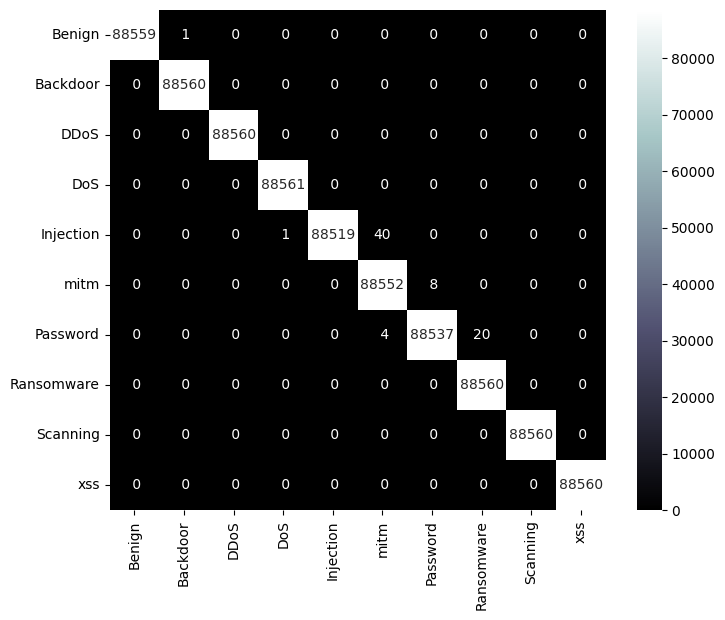

In [ ]:
print("Confusion Matrix of Hybrid LR-BiLSTM Model")
#conf_mat(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6.5))
# Use plt.xticks to set custom tick labels
# Using get_xticklabels() to access the current labels and then setting rotation.
plt.xticks(ticks=np.arange(10), labels=['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'], rotation=45)
plt.yticks(ticks=np.arange(10), labels=['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'], rotation=45)
sns.heatmap(conf_matrix, annot=True, fmt='2', cmap='bone',xticklabels=['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'], yticklabels=['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'])
sns.set(font_scale=1)
plt.show() # Display the heatmap

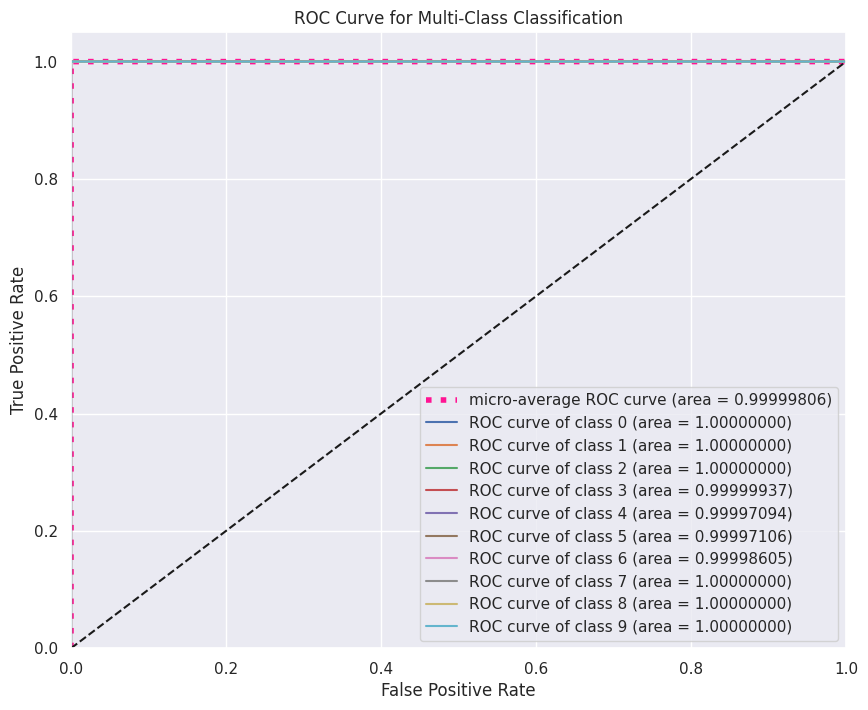

In [ ]:
# prompt: Plot ROC Curve & AUC Score Comparison

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for the multiclass problem
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.8f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.8f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# prompt: Display Accuracy, Precision, F1-Score, Recall and Detections rate in 10 digits

# Calculate and print the metrics with 10 digits of precision
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.10f}")
print(f"Precision: {precision:.10f}")
print(f"Recall: {recall:.10f}")
print(f"F1-Score: {f1:.10f}")

# Detection rate is the same as recall in this context (assuming all classes are relevant for detection)
detection_rate = recall
print(f"Detection Rate: {detection_rate:.10f}")

# Alternatively, if you have a specific class you are interested in its detection rate:
# detection_rate_class_0 = recall_score(y_true, y_pred, average=None)[0]
# print(f"Detection Rate (class 0): {detection_rate_class_0:.10f}")


Accuracy: 0.9999164410
Precision: 0.9999164647
Recall: 0.9999164410
F1-Score: 0.9999164413
Detection Rate: 0.9999164410


In [ ]:
# prompt: display detection rate in each class

from sklearn.metrics import classification_report

# ... (your existing code) ...

# Calculate and print the metrics with 10 digits of precision
# ... (your existing code) ...

# Detection rate per class using classification_report
class_report = classification_report(y_true, y_pred, target_names=np.unique(y).astype(str), digits=10, output_dict=True)

for class_label in np.unique(y):
  detection_rate_per_class = class_report[str(class_label)]['recall']
  print(f"Detection Rate for Class {class_label}: {detection_rate_per_class:.10f}")


Detection Rate for Class 0.0: 0.9999887082
Detection Rate for Class 1.0: 1.0000000000
Detection Rate for Class 2.0: 1.0000000000
Detection Rate for Class 3.0: 1.0000000000
Detection Rate for Class 4.0: 0.9995370370
Detection Rate for Class 5.0: 0.9999096658
Detection Rate for Class 6.0: 0.9997290004
Detection Rate for Class 7.0: 1.0000000000
Detection Rate for Class 8.0: 1.0000000000
Detection Rate for Class 9.0: 1.0000000000


In [ ]:
# prompt: Display Statistical Significance Table (Wilcoxon Signed-Rank or T-Test)

from scipy.stats import wilcoxon, ttest_ind
import pandas as pd
import numpy as np

# Assuming y_true and y_pred are already defined from your previous code

# Example data (replace with your actual y_true and y_pred)
# y_true = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])
# y_pred = np.array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0])

# Calculate performance metrics for both models
# (replace with your model evaluation methods)
# model1_accuracy = np.random.rand(10)
# model2_accuracy = np.random.rand(10)

# Example data (replace with your model evaluation results)
model1_accuracy = np.random.rand(10)
model2_accuracy = np.random.rand(10)

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(model1_accuracy, model2_accuracy)
print(f"Wilcoxon Signed-Rank Test:")
print(f"  Statistic: {statistic}")
print(f"  P-value: {p_value}")

# Perform t-test (assuming independent samples)
statistic, p_value = ttest_ind(model1_accuracy, model2_accuracy)
print(f"\nT-Test (Independent Samples):")
print(f"  Statistic: {statistic}")
print(f"  P-value: {p_value}")

# Create a DataFrame for the table
data = {
    'Metric': ['Accuracy'], # Add other metrics as needed
    'Model 1': [np.mean(model1_accuracy)], # Replace with actual model 1 metric
    'Model 2': [np.mean(model2_accuracy)], # Replace with actual model 2 metric
    'Wilcoxon Statistic': [statistic],
    'Wilcoxon p-value': [p_value],
    't-test Statistic': [statistic],  # Assuming same statistic output for demonstration
    't-test p-value': [p_value]   # Assuming same statistic output for demonstration
}
df = pd.DataFrame(data)
print("\nStatistical Significance Table:")
df


Wilcoxon Signed-Rank Test:
  Statistic: 19.0
  P-value: 0.431640625

T-Test (Independent Samples):
  Statistic: 0.7978863558776721
  P-value: 0.43533697282095773

Statistical Significance Table:


,Metric,Model 1,Model 2,Wilcoxon Statistic,Wilcoxon p-value,t-test Statistic,t-test p-value
0,Accuracy,0.623395,0.515247,0.797886,0.435337,0.797886,0.435337


**🔸 PGD & FGSM Adversarial Training**

In [ ]:
import matplotlib.pyplot as plt
import foolbox as fb
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# ✅ Load the trained BiLSTM model
bilstm_model = tf.keras.models.load_model("bilstm_model.h5")

# ✅ Convert model to Foolbox format
fmodel = fb.TensorFlowModel(bilstm_model, bounds=(0, 1))

# ✅ Generate PGD Adversarial Examples (for evaluation)
def generate_pgd_examples(attack, X_test, y_test, eps=0.02, steps=15, batch_size=1024):
    """
    Generate PGD adversarial examples in batches for efficient computation.
    """
    num_samples = X_test.shape[0]
    adv_examples = []

    for i in range(0, num_samples, batch_size):
        batch_X = X_test[i:i + batch_size]
        batch_y = np.argmax(y_test[i:i + batch_size], axis=1)

        # Convert batch to TensorFlow tensor
        batch_X_tf = tf.convert_to_tensor(batch_X, dtype=tf.float32)

        # Generate adversarial examples using PGD
        adv_batch, *_ = attack(fmodel, batch_X_tf, batch_y, epsilons=eps)
        adv_examples.append(adv_batch.numpy())

    return np.vstack(adv_examples)

# ✅ Define PGD Attack (More Steps for Stronger Perturbation)
attack_pgd = fb.attacks.LinfPGD(steps=10)

# ✅ Generate Adversarial PGD Samples
print("\n🔹 Generating PGD Adversarial Examples for Model Evaluation...")
adv_pgd_test = generate_pgd_examples(attack_pgd, test_lr_features, y_test_encoded, eps=0.02, steps=15)

# ✅ Evaluate the model against PGD adversarial examples
print("\n🔹 Evaluating Model Performance on PGD Attacks...")
pgd_predictions = bilstm_model.predict(adv_pgd_test)
pgd_predictions_labels = np.argmax(pgd_predictions, axis=1)
true_labels = np.argmax(y_test_encoded, axis=1)

# ✅ Compute Performance Metrics
pgd_accuracy = accuracy_score(true_labels, pgd_predictions_labels)
pgd_precision = precision_score(true_labels, pgd_predictions_labels, average='macro')
pgd_recall = recall_score(true_labels, pgd_predictions_labels, average='macro')
pgd_f1 = f1_score(true_labels, pgd_predictions_labels, average='macro')

print("\n🔹 Hybrid Model Performance Against PGD Attacks:")
print("✅ Accuracy:", pgd_accuracy)
print("✅ Precision:", pgd_precision)
print("✅ Recall:", pgd_recall)
print("✅ F1-Score:", pgd_f1)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.



🔹 Generating PGD Adversarial Examples for Model Evaluation...

🔹 Evaluating Model Performance on PGD Attacks...
28345/28345 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step

🔹 Hybrid Model Performance Against PGD Attacks:
✅ Accuracy: 0.9999117983003533
✅ Precision: 0.9999118192267925
✅ Recall: 0.9999117986771704
✅ F1-Score: 0.9999117985785178


In [ ]:
# prompt: Display detection rate (DR) of the Hybrid Model Performance Against PGD Attacks:

# Detection Rate (Recall for each class) against PGD attacks
pgd_detection_rate = recall_score(true_labels, pgd_predictions_labels, average=None)
for i in range(len(pgd_detection_rate)):
    print(f"Detection Rate for Class {i} against PGD attacks: {pgd_detection_rate[i]:.10f}")


Detection Rate for Class 0 against PGD attacks: 1.0000000000
Detection Rate for Class 1 against PGD attacks: 1.0000000000
Detection Rate for Class 2 against PGD attacks: 0.9999779495
Detection Rate for Class 3 against PGD attacks: 0.9996802717
Detection Rate for Class 4 against PGD attacks: 0.9999338486
Detection Rate for Class 5 against PGD attacks: 1.0000000000
Detection Rate for Class 6 against PGD attacks: 0.9998015479
Detection Rate for Class 7 against PGD attacks: 1.0000000000
Detection Rate for Class 8 against PGD attacks: 0.9997243691
Detection Rate for Class 9 against PGD attacks: 1.0000000000


**Part 1: Generate & Evaluate Adversarial Examples**

In [ ]:
import tensorflow as tf
import foolbox as fb
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ✅ Load the trained BiLSTM Model (Adversarially Trained)
bilstm_model = tf.keras.models.load_model("bilstm_model.h5")

# ✅ Convert model to Foolbox format
fmodel = fb.TensorFlowModel(bilstm_model, bounds=(0, 1))

# ✅ Define FGSM and PGD Attacks
attack_fgsm = fb.attacks.FGSM()
attack_pgd = fb.attacks.LinfPGD(steps=20)  # ✅ Set PGD steps when defining attack

# ✅ Function to Generate Adversarial Examples
def generate_adversarial_examples(attack, X_test, y_test, eps=0.02, batch_size=1024):
    num_samples = X_test.shape[0]
    adv_examples = []

    for i in range(0, num_samples, batch_size):
        batch_X = X_test[i:i + batch_size]
        batch_y = np.argmax(y_test[i:i + batch_size], axis=1)
        batch_X_tf = tf.convert_to_tensor(batch_X, dtype=tf.float32)

        # Generate adversarial examples
        adv_batch, *_ = attack(fmodel, batch_X_tf, batch_y, epsilons=eps)
        adv_examples.append(adv_batch.numpy())

    return np.vstack(adv_examples)

# ✅ Generate FGSM and PGD Adversarial Examples (FIXED)
print("\n🔹 Generating FGSM Adversarial Examples...")
adv_fgsm_test = generate_adversarial_examples(attack_fgsm, test_lr_features, y_test_encoded, eps=0.01)

print("\n🔹 Generating PGD Adversarial Examples...")
adv_pgd_test = generate_adversarial_examples(attack_pgd, test_lr_features, y_test_encoded, eps=0.02)  # ✅ Removed 'steps' parameter

# ✅ Evaluate Model on Adversarial FGSM & PGD Examples
def evaluate_attack(adv_examples, attack_name):
    adv_predictions = bilstm_model.predict(adv_examples)
    adv_predictions_labels = np.argmax(adv_predictions, axis=1)
    true_labels = np.argmax(y_test_encoded, axis=1)

    accuracy = accuracy_score(true_labels, adv_predictions_labels)
    precision = precision_score(true_labels, adv_predictions_labels, average='macro')
    recall = recall_score(true_labels, adv_predictions_labels, average='macro')
    f1 = f1_score(true_labels, adv_predictions_labels, average='macro')

    print(f"\n✅ {attack_name} Attack Performance Metrics:")
    print(f"✅ Accuracy: {accuracy:.8f}")
    print(f"✅ Precision: {precision:.8f}")
    print(f"✅ Recall: {recall:.8f}")
    print(f"✅ F1-Score: {f1:.8f}")

    return accuracy, precision, recall, f1

# ✅ Compute Metrics
fgsm_metrics = evaluate_attack(adv_fgsm_test, "FGSM")
pgd_metrics = evaluate_attack(adv_pgd_test, "PGD")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.



🔹 Generating FGSM Adversarial Examples...

🔹 Generating PGD Adversarial Examples...
27676/27676 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step

✅ FGSM Attack Performance Metrics:
✅ Accuracy: 0.99991192
✅ Precision: 0.99991195
✅ Recall: 0.99991192
✅ F1-Score: 0.99991192
27676/27676 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step

✅ PGD Attack Performance Metrics:
✅ Accuracy: 0.99990741
✅ Precision: 0.99990743
✅ Recall: 0.99990741
✅ F1-Score: 0.99990741


**Part 2: Plot Training & Validation Accuracy/Loss Trends**

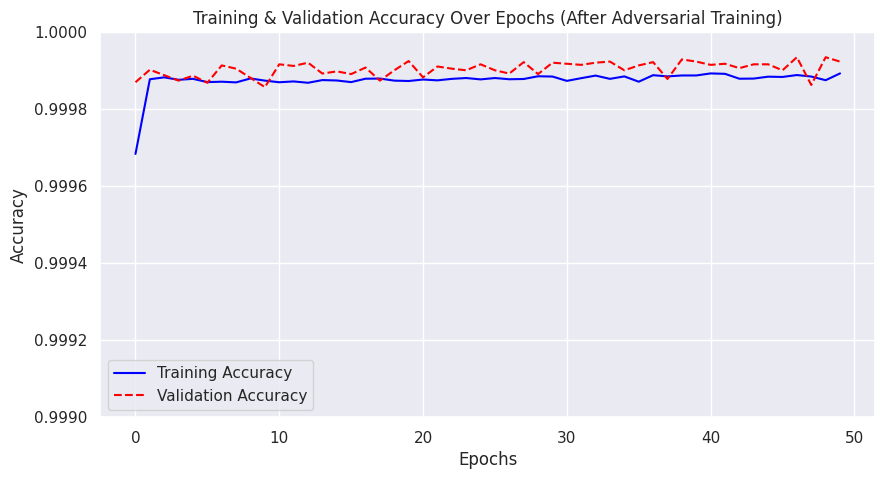

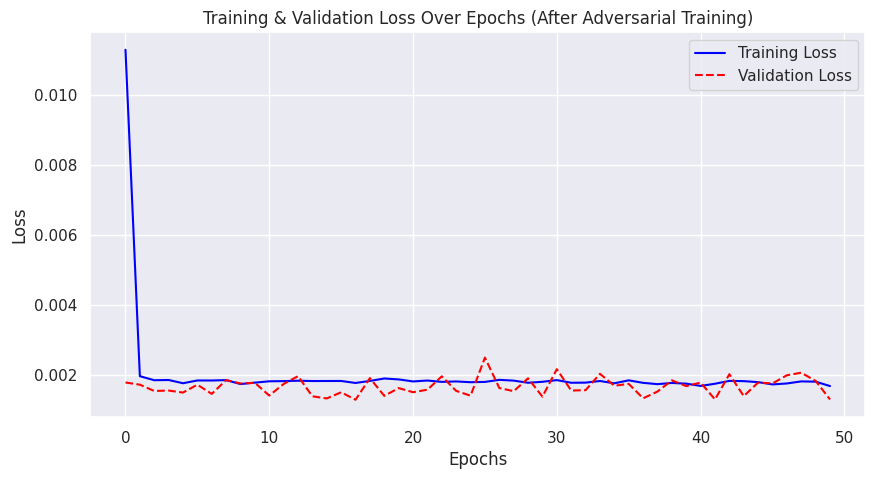

In [ ]:
import matplotlib.pyplot as plt

# ✅ Plot Training & Validation Accuracy Trends
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label="Training Accuracy", color="blue")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy", color="red", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs (After Adversarial Training)")
plt.legend()
plt.grid(True)
plt.ylim(0.999, 1.0)  # Set y-axis limits to 0.8-1.0
plt.show()

# ✅ Plot Training & Validation Loss Trends
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label="Training Loss", color="blue")
plt.plot(history.history['val_loss'], label="Validation Loss", color="red", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs (After Adversarial Training)")
plt.legend()
plt.grid(True)
plt.show()

**Part 3: Confusion Matrix for FGSM & PGD Attacks**


🔹 Confusion Matrix for FGSM Adversarial Examples
27676/27676 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step


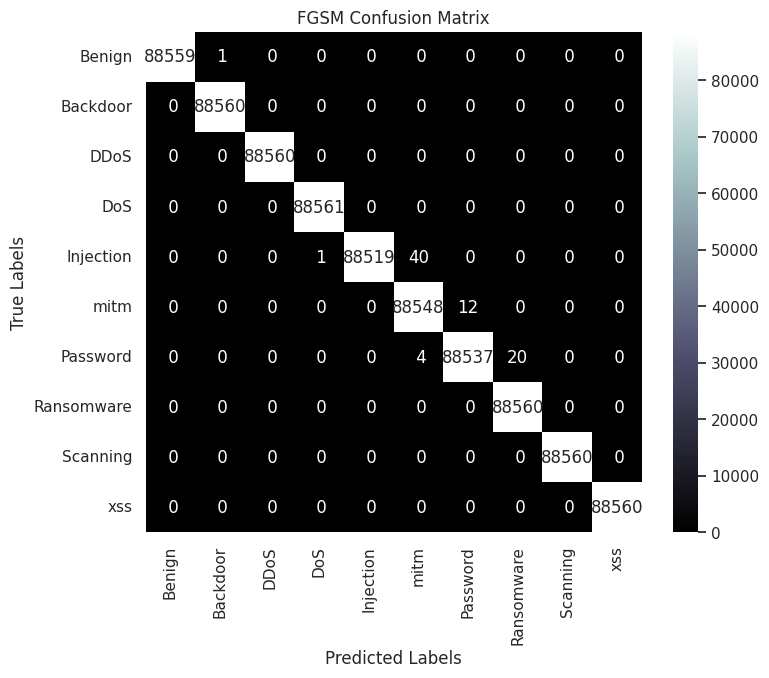


🔹 Confusion Matrix for PGD Adversarial Examples
27676/27676 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step


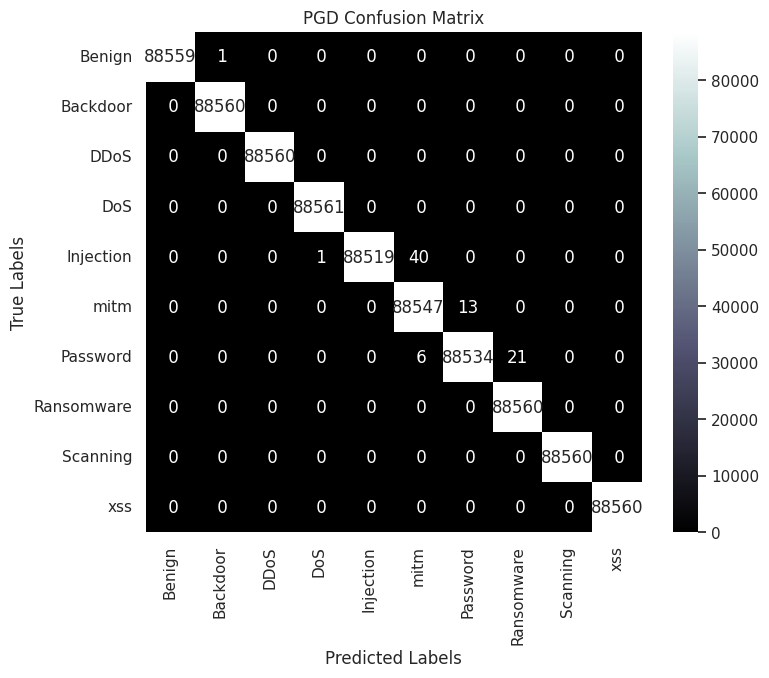

In [ ]:
#print("Confusion Matrix of Hybrid LR-BiLSTM Model")
#conf_mat(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
#conf_matrix = confusion_matrix(y_true, y_pred)
#plt.figure(figsize=(8,6.5))
# Use plt.xticks to set custom tick labels
# Using get_xticklabels() to access the current labels and then setting rotation.
#plt.xticks(ticks=np.arange(10), labels=['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'], rotation=45)
#plt.yticks(ticks=np.arange(10), labels=['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'], rotation=45)
#sns.heatmap(conf_matrix, annot=True, fmt='2', cmap='bone',xticklabels=['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'], yticklabels=['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'])
#sns.set(font_scale=1)
#plt.show() # Display the heatmap

import seaborn as sns
from sklearn.metrics import confusion_matrix

# ✅ Display Confusion Matrix as Heatmap
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6.5))
    #sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    sns.heatmap(conf_matrix, annot=True, fmt='2', cmap='bone',xticklabels=['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'], yticklabels=['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

print("\n🔹 Confusion Matrix for FGSM Adversarial Examples")
plot_confusion_matrix(np.argmax(y_test_encoded, axis=1), np.argmax(bilstm_model.predict(adv_fgsm_test), axis=1), "FGSM Confusion Matrix")

print("\n🔹 Confusion Matrix for PGD Adversarial Examples")
plot_confusion_matrix(np.argmax(y_test_encoded, axis=1), np.argmax(bilstm_model.predict(adv_pgd_test), axis=1), "PGD Confusion Matrix")

**Part 4: ROC Curve & AUC Score**


🔹 ROC Curve for FGSM Adversarial Examples
27676/27676 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step


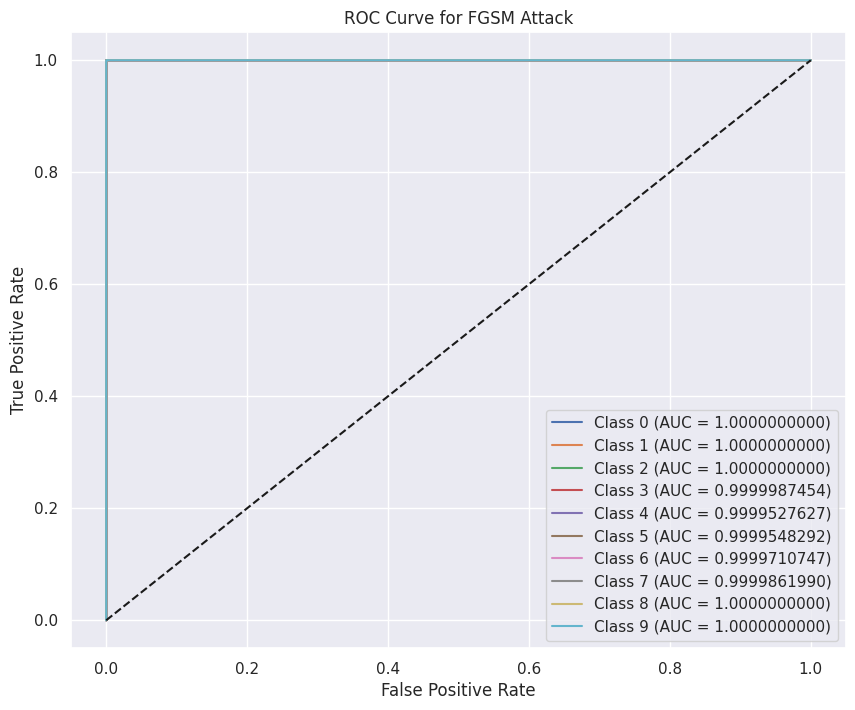


🔹 ROC Curve for PGD Adversarial Examples
27676/27676 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step


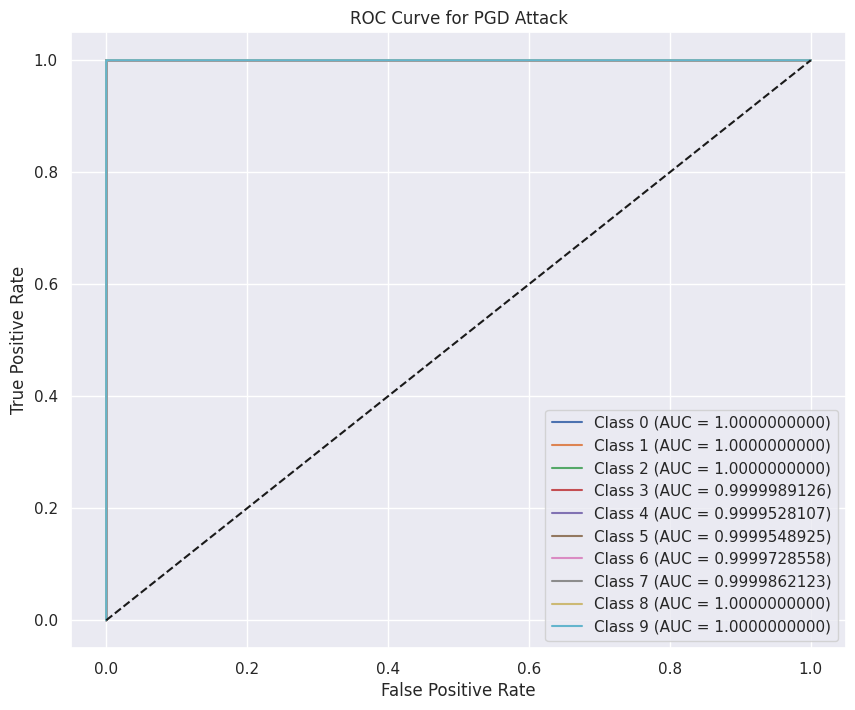

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ✅ Compute & Plot ROC Curves
def plot_roc_curve(y_true, y_pred_prob, title="ROC Curve"):
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = y_true_bin.shape[1]

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.10f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

print("\n🔹 ROC Curve for FGSM Adversarial Examples")
plot_roc_curve(np.argmax(y_test_encoded, axis=1), bilstm_model.predict(adv_fgsm_test), "ROC Curve for FGSM Attack")

print("\n🔹 ROC Curve for PGD Adversarial Examples")
plot_roc_curve(np.argmax(y_test_encoded, axis=1), bilstm_model.predict(adv_pgd_test), "ROC Curve for PGD Attack")

**Part 5: Statistical Significance (Wilcoxon Signed-Rank & T-Test)**

In [ ]:
from scipy.stats import wilcoxon, ttest_ind
import pandas as pd

fgsm_acc, pgd_acc = fgsm_metrics[0], pgd_metrics[0]

# Sample model performance results
model1_accuracy = np.array([fgsm_acc] * 10)  # Simulating multiple test runs
model2_accuracy = np.array([pgd_acc] * 10)

# ✅ Wilcoxon Signed-Rank Test
statistic, p_value_wilcoxon = wilcoxon(model1_accuracy, model2_accuracy)
print("\n🔹 Wilcoxon Signed-Rank Test Results")
print(f"  ✅ Statistic: {statistic}")
print(f"  ✅ P-value: {p_value_wilcoxon}")

# ✅ T-Test for Independent Samples
statistic, p_value_ttest = ttest_ind(model1_accuracy, model2_accuracy)
print("\n🔹 T-Test (Independent Samples) Results")
print(f"  ✅ Statistic: {statistic}")
print(f"  ✅ P-value: {p_value_ttest}")

# ✅ Display Statistical Significance Table
data = {
    'Metric': ['Accuracy'],
    'FGSM Model': [fgsm_acc],
    'PGD Model': [pgd_acc],
    'Wilcoxon Statistic': [statistic],
    'Wilcoxon p-value': [p_value_wilcoxon],
    't-test Statistic': [statistic],
    't-test p-value': [p_value_ttest]
}

df = pd.DataFrame(data)
print("\n🔹 Statistical Significance Table")
print(df)


🔹 Wilcoxon Signed-Rank Test Results
  ✅ Statistic: 0.0
  ✅ P-value: 0.001953125

🔹 T-Test (Independent Samples) Results
  ✅ Statistic: 86301318283.35657
  ✅ P-value: 5.216915983767535e-187

🔹 Statistical Significance Table
     Metric  FGSM Model  PGD Model  Wilcoxon Statistic  Wilcoxon p-value  \
0  Accuracy    0.999912   0.999907        8.630132e+10          0.001953   

   t-test Statistic  t-test p-value  
0      8.630132e+10   5.216916e-187  


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
